In [28]:
from pygdsm import GlobalSkyModel2016, GlobalSkyModel
import healpy as hp
import numpy as np
from numpy.linalg import svd
from scipy.special import eval_legendre
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from anstey.generate import T_CMB
from src.blockmat import BlockMatrix,BlockVector
import fig_gen as fg
import src.observing as OBS
import src.beam_functions as BF
import src.spherical_harmonics as SH
import src.forward_model as FM
import src.sky_models as SM
import src.map_making as MM
import src.plotting as PL
from emcee import EnsembleSampler
import src.inference as INF
from chainconsumer import ChainConsumer
from functools import partial

alm2temp = 1/np.sqrt(4*np.pi)
RS = SH.RealSphericalHarmonics()

def cm21_globalT(nu, A=-0.2, nu0=80.0, dnu = 5.0):
    chi = (nu - nu0) / dnu
    Tmon = A * np.exp(-0.5 * chi * chi)
    return Tmon

def cm21_dipoleT(nu, A=-0.2, nu0=80.0, dnu = 5.0):
    chi = (nu - nu0) / dnu
    Tmon = cm21_globalT(nu, A, nu0, dnu)
    dTmon = -chi / dnu * Tmon
    Tdip = (Tmon - nu * dTmon)
    return Tdip
nuarr = np.linspace(50,100,51)

In [45]:
# Mapmaking pipeline parameters.
nside   = 32
lmax = 32
lmod = 5
Nlmax   = RS.get_size(lmax)
Nlmod   = RS.get_size(lmod)

# Observation and binning params.
Ntau  = None
Nt    = 24
times = np.linspace(0, 24, Nt, endpoint=False)
nuarr = np.linspace(50,100,51)
lats = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])
chrom = None
basemap_err = 0    # BASEMAP ERROR
err_type='idx'

# Cosmological parameters.
cm21_params = OBS.cm21_params

# Foreground correction reference frequency.
err_ref = 70

# Generate foreground and 21-cm signal alm
cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=OBS.cm21_params)
fg_alm   = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, 
    use_mat_Y=True, delta=SM.basemap_err_to_delta(basemap_err, ref_freq=err_ref), 
    err_type=err_type, seed=100, meancorr=False)
fid_alm  = fg_alm + cm21_alm

# Generate observation matrix for the modelling and for the observations.
if chrom is not None:
    if not isinstance(chrom, bool):
        chromfunc = partial(BF.fwhm_func_tauscher, c=chrom)
    else:
        chromfunc = BF.fwhm_func_tauscher
    mat_A = FM.calc_observation_matrix_multi_zenith_driftscan_chromatic(nuarr, nside, lmax, Ntau=Ntau, lats=lats, times=times, return_mat=False, beam_use=BF.beam_cos_FWHM, chromaticity=chromfunc)
    mat_A_mod = mat_A[:,:Nlmod]
elif chrom is None:
    narrow_cosbeam  = lambda x: BF.beam_cos(x, 0.8)
    mat_A = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, Ntau=Ntau, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=False)
    mat_A = BlockMatrix(mat=mat_A, mode='block', nblock=len(nuarr))
    mat_A_mod = mat_A[:,:Nlmod]

# Perform fiducial observations
d = mat_A @ fid_alm
dnoisy, noise_covar = SM.add_noise(d, 1, Ntau=len(times), t_int=1e5, seed=100)#t_int=100, seed=456)#
sample_noise = np.sqrt(noise_covar.block[0][0,0])
print(f"Data generated with noise {sample_noise} K at 50 MHz in the first bin")

# Calculate the missing-modes observation matrix.
mat_A_unmod = BlockMatrix(mat_A.block[:,:,Nlmod:])

# Generate a missing-modes correction analytically.
alm_mean, alm_cov = SM.gsma_corr(lmod, lmax, nside, nuarr, basemap_err, ref_freq=err_ref)
data_corr  = mat_A_unmod @ alm_mean
covar_corr = mat_A_unmod @ alm_cov @ mat_A_unmod.T

# Reconstruct the max likelihood estimate of the alm
mat_W, cov = MM.calc_ml_estimator_matrix(mat_A=mat_A_mod, mat_N=noise_covar+covar_corr, cov=True, cond=True)
if isinstance(cov, BlockMatrix):
    alm_error = np.sqrt(cov.diag)
else:
    alm_error = np.sqrt(np.diag(cov))
print("Computing rec alm")
if isinstance(mat_W, BlockMatrix):
    rec_alm = mat_W @ (dnoisy - data_corr)
else:
    rec_alm = mat_W @ (dnoisy - data_corr).vector

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Data generated with noise 0.0021879163031514382 K at 50 MHz in the first bin
Loaded mean and covar correction for nside<32>_lmax<32>_bmerr<0>
1/condition #: 6.936317863459959e-08
Computing rec alm


In [46]:
a1m1 = rec_alm[1]
a1m1_err = alm_error[1::Nlmod]

In [47]:
# Visualise things

In [48]:
fg_alm = BlockVector(fg_alm,nblock=len(nuarr))
cm21_alm = BlockVector(cm21_alm,nblock=len(nuarr))

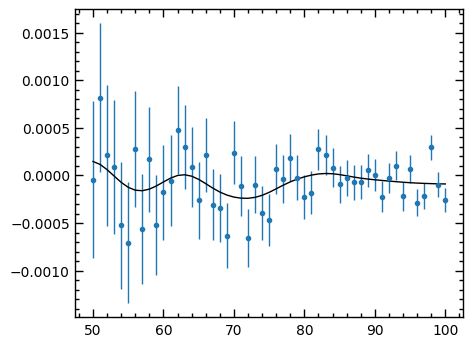

In [49]:
from scipy.ndimage import gaussian_filter1d
res_smooth = gaussian_filter1d(a1m1 - fg_alm[1], sigma=3)
plt.errorbar(nuarr, a1m1 - fg_alm[1], a1m1_err, fmt='.')
plt.plot(nuarr, res_smooth, color='k')
plt.show()

In [2]:
def a1m_fg_mod(theta):
    assert len(theta) == 5
    A, alpha = theta[:2]
    zetas    = theta[2:]
    exponent = [zetas[i]*np.log(nuarr/60)**(i+2) for i in range(len(zetas))]
    a1m_fg   = (A*1e3)*(nuarr/60)**(-alpha) * np.exp(np.sum(exponent, 0))
    return a1m_fg

a1m_fg_mod_cf = lambda nuarr, *theta: a1m_fg_mod(theta)


def a1m_mod(theta):
    assert len(theta) == 5 + 1
    theta_fg = theta[:5]
    theta_21 = theta[-1]
    a1m_cm21 = -cm21_dipoleT(nuarr, *OBS.cm21_params)
    a1m_fg   = a1m_fg_mod(theta_fg)
    return theta_21*a1m_cm21 + a1m_fg

In [29]:
# Make a curve fit estimate of the foreground parameters.

In [30]:
res_1m1 = curve_fit(f=a1m_fg_mod_cf, xdata=nuarr, ydata=a1m1, sigma=a1m1_err, p0=[10, 2, 0.1, 0.1, 0.1])

In [31]:
nwalkers = 64
ndim     = 5 + 1
steps    = 3000
burn_in  = 1000

p0 = (
    list(res_1m1[0])
    + [1e-3]
)
p0     = np.array(p0)
pos    = p0*(1 + 1e-2*np.random.randn(nwalkers, ndim))

priors = [
    [-1, 4],   # cm21 poly1
    [1.5, 3.5], 
    [-2, 2.1], 
    [-0.011, 0.01], 
    [-0.011, 0.01], 
    [-1e-2, 1e-2]  # Dip mag
]
priors = np.array(priors)

sampler = EnsembleSampler(nwalkers, ndim, INF.log_posterior, 
                    args=(a1m1, a1m1_err, a1m_mod, priors))
_=sampler.run_mcmc(pos, nsteps=steps, progress=True, skip_initial_state_check=True)
chain_mcmc = sampler.get_chain(flat=True, discard=burn_in)

100%|██████████████████████████████████████| 3000/3000 [00:16<00:00, 184.48it/s]


/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_79151/2469361507.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


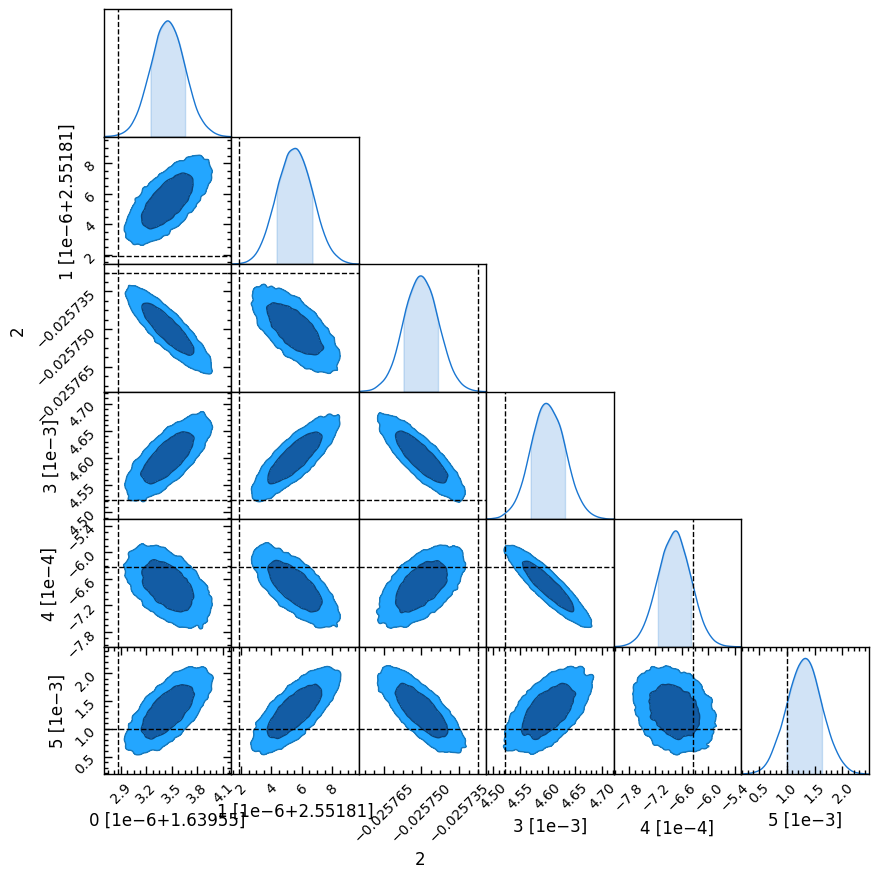

In [32]:
c = ChainConsumer()
c.add_chain(chain_mcmc)
f = c.plotter.plot(truth=p0)
f.show()

<ErrorbarContainer object of 3 artists>

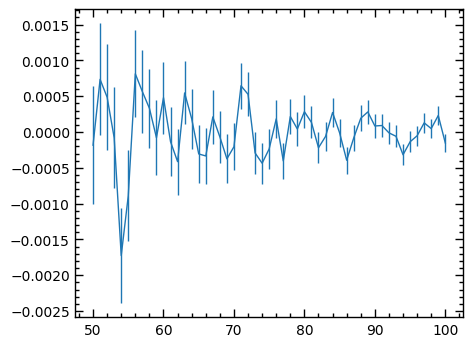

In [33]:
theta_mean = np.mean(chain_mcmc,axis=0)
plt.errorbar(nuarr, a1m1-a1m_mod(theta_mean), a1m1_err)

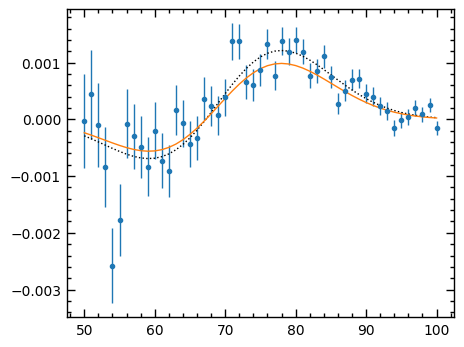

In [34]:
theta_21 = theta_mean[-1]

plt.errorbar(nuarr, a1m1 - fg_alm[1], a1m1_err, fmt='.')
plt.plot(nuarr, cm21_alm[1], linestyle=':', color='k')
plt.plot(nuarr, a1m_mod([0,0,0,0,0]+[theta_21]))
plt.show()

In [35]:
theta_21 = theta_mean[-1]
2*theta_21/(np.percentile(chain_mcmc[:,-1],84)-np.percentile(chain_mcmc[:,-1],16))

4.2271861346069395

In [ ]:
# Make a function to encapsulate this with the inputs: noise seed, basemap error, integration time

In [3]:
def main_func(seed=123, basemap_err=0, t_int=1e3, chrom=None):
    # Mapmaking pipeline parameters.
    nside   = 32
    lmax = 32
    lmod = 5
    Nlmax   = RS.get_size(lmax)
    Nlmod   = RS.get_size(lmod)
    
    # Observation and binning params.
    Ntau  = None
    Nt    = 24
    times = np.linspace(0, 24, Nt, endpoint=False)
    nuarr = np.linspace(50,100,51)
    lats = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])
    chrom = chrom
    basemap_err = basemap_err  # BASEMAP ERROR
    err_type='idx'
    
    # Cosmological parameters.
    cm21_params = OBS.cm21_params
    
    # Foreground correction reference frequency.
    err_ref = 70
    
    # Generate foreground and 21-cm signal alm
    cm21_alm = SM.cm21_gauss_mondip_alm(nu=nuarr, lmax=lmax, params=OBS.cm21_params_mondip)
    fg_alm   = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, 
        use_mat_Y=True, delta=SM.basemap_err_to_delta(basemap_err, ref_freq=err_ref), 
        err_type=err_type, seed=seed, meancorr=False)
    fid_alm  = fg_alm + cm21_alm
    
    # Generate observation matrix for the modelling and for the observations.
    if chrom is not None:
        if not isinstance(chrom, bool):
            chromfunc = partial(BF.fwhm_func_tauscher, c=chrom)
        else:
            chromfunc = BF.fwhm_func_tauscher
        mat_A = FM.calc_observation_matrix_multi_zenith_driftscan_chromatic(nuarr, nside, lmax, Ntau=Ntau, lats=lats, times=times, return_mat=False, beam_use=BF.beam_cos_FWHM, chromaticity=chromfunc)
        mat_A_mod = mat_A[:,:Nlmod]
    elif chrom is None:
        narrow_cosbeam  = lambda x: BF.beam_cos(x, 0.8)
        mat_A = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, Ntau=Ntau, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=False)
        mat_A = BlockMatrix(mat=mat_A, mode='block', nblock=len(nuarr))
        mat_A_mod = mat_A[:,:Nlmod]
    
    # Perform fiducial observations
    d = mat_A @ fid_alm
    dnoisy, noise_covar = SM.add_noise(d, 1, Ntau=len(times), t_int=t_int, seed=seed)#t_int=100, seed=456)#
    sample_noise = np.sqrt(noise_covar.block[0][0,0])
    print(f"Data generated with noise {sample_noise} K at 50 MHz in the first bin")
    
    # Calculate the missing-modes observation matrix.
    mat_A_unmod = BlockMatrix(mat_A.block[:,:,Nlmod:])
    
    # Generate a missing-modes correction analytically.
    alm_mean, alm_cov = SM.gsma_corr(lmod, lmax, nside, nuarr, basemap_err, ref_freq=err_ref)
    data_corr  = mat_A_unmod @ alm_mean
    covar_corr = mat_A_unmod @ alm_cov @ mat_A_unmod.T
    
    # Reconstruct the max likelihood estimate of the alm
    mat_W, cov = MM.calc_ml_estimator_matrix(mat_A=mat_A_mod, mat_N=noise_covar+covar_corr, cov=True, cond=True)
    if isinstance(cov, BlockMatrix):
        alm_error = np.sqrt(cov.diag)
    else:
        alm_error = np.sqrt(np.diag(cov))
    print("Computing rec alm")
    if isinstance(mat_W, BlockMatrix):
        rec_alm = mat_W @ (dnoisy - data_corr)
    else:
        rec_alm = mat_W @ (dnoisy - data_corr).vector

    # Extract one dipole mode
    a1m1 = rec_alm[1]
    a1m1_err = alm_error[1::Nlmod]

    # Fit it with log-polyn for FG parameter estimates
    res_1m1 = curve_fit(f=a1m_fg_mod_cf, xdata=nuarr, ydata=a1m1, sigma=a1m1_err, p0=[10, 2, 0.1, 0.1, 0.1])

    # Fit foreground and 21-cm dipole profile with mcmc
    nwalkers = 64
    ndim     = 5 + 1
    steps    = 3000
    burn_in  = 1000
    
    p0 = (
        list(res_1m1[0])
        + [1e-3]
    )
    p0     = np.array(p0)
    pos    = p0*(1 + 1e-2*np.random.randn(nwalkers, ndim))
    
    priors = [
        [-1, 4],   # cm21 poly1
        [1.5, 3.5], 
        [-2, 2.1], 
        [-0.011, 0.01], 
        [-0.011, 0.01], 
        [-1e-2, 1e-2]  # Dip mag
    ]
    priors = np.array(priors)
    
    sampler = EnsembleSampler(nwalkers, ndim, INF.log_posterior, 
                        args=(a1m1, a1m1_err, a1m_mod, priors))
    _=sampler.run_mcmc(pos, nsteps=steps, progress=True, skip_initial_state_check=True)
    chain_mcmc = sampler.get_chain(flat=True, discard=burn_in)
    theta_mean = np.mean(chain_mcmc,axis=0)
    theta_21 = theta_mean[-1]

    del mat_A
    del mat_A_mod
    del mat_A_unmod
    del mat_W
    
    return 2*theta_21/(np.percentile(chain_mcmc[:,-1],84)-np.percentile(chain_mcmc[:,-1],16))
    
    

In [ ]:
# Scan parameter space:
bm_errs = [0, 0.5, 1]
t_ints  = np.logspace(1,7,10)
N = 10
'''
tests = {
    "ideal":[0, 1e5, None],
    "bm1":[0.5, 1e5, None],
    "bm2":[1., 1e5, None],
    "tint1":[0, 1e4, None],
    "tint2":[0, 1e3, None],
    "chrom1":[0, 1e5, 1.6e-2],
    "chrom2":[0, 1e5, 3.4e-2],
}
'''
'''
tests = {
    "bm3":[2., 1e5, None],
    "tint3":[0, 1e2, None],
    "chrom3":[0, 1e5, 5.2e-2],
}
'''
tests = {
    "real":[1., 1e4, None]
}
for name, vals in tests.items():
    snrs = []
    res  = []
    for n in range(N):
        snrs.append(main_func(123+n, vals[0], vals[1], vals[2]))
    
    minus_2sig = np.percentile(snrs,2.2)
    minus_1sig = np.percentile(snrs,2.2+13.6)
    plus_1sig  = np.percentile(snrs,2.2+13.6+2*34.1)
    plus_2sig  = np.percentile(snrs,2.2+2*13.6+2*34.1)
    
    res.append([minus_2sig, minus_1sig, plus_1sig, plus_2sig])

    np.save(f"zzz_{name}.npy", res)

In [79]:
# Load all data
ideal  = np.load("zzz_ideal.npy")
bm1    = np.load("zzz_bm1.npy")
bm2    = np.load("zzz_bm2.npy")
bm3    = np.load("zzz_bm3.npy")
chrom1 = np.load("zzz_chrom1.npy")
chrom2 = np.load("zzz_chrom2.npy")
chrom3 = np.load("zzz_chrom3.npy")
tint1  = np.load("zzz_tint1.npy")
tint2  = np.load("zzz_tint2.npy")
tint3  = np.load("zzz_tint3.npy")
real   = np.load("zzz_real.npy")

def get_stats(data, label):
    data = data[0]
    data_dict = {
        "whislo" : data[0], 
        "whishi" : data[-1],
        "q1" : data[1],
        "q3" : data[2],
        "med" : (data[1]+data[2])/2,
        "label" : label
    }
    return data_dict

all_stats = [
    get_stats(ideal,  "ideal\ncase"),
    get_stats(bm1,    r"$\sigma_T=0.5\%$"),
    get_stats(bm2,    r"$\sigma_T=1.0\%$"),
    get_stats(bm3,    r"$\sigma_T=2.0\%$"),
    get_stats(chrom1, "c=1.6e-2"),
    get_stats(chrom2, "c=3.4e-2"),
    get_stats(chrom3, "c=5.2e-2"),
    get_stats(tint1,  "$10^4$ hours"),
    get_stats(tint2,  "$10^3$ hours"),
    get_stats(tint3,  "$10^2$ hours"),
    get_stats(real,   "combined"),
]

/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_79855/1597264460.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


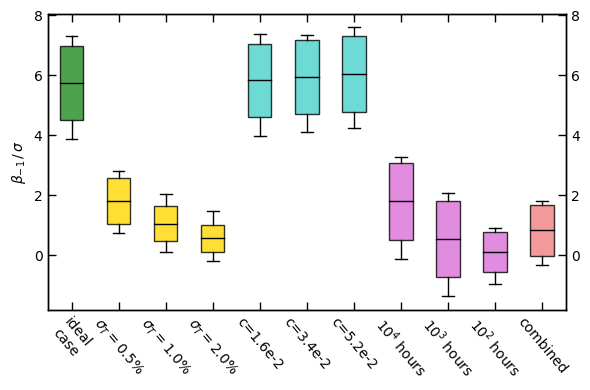

In [80]:
fig, ax = plt.subplots(figsize=(6,4))
bp = ax.bxp(all_stats, showfliers=False, patch_artist=True, boxprops={'facecolor': 'forestgreen', 'alpha':0.8}, medianprops=dict(color='k'))
ax.tick_params(axis='x', labelrotation=-50)
ax.minorticks_off()
ax.set_ylabel(r"$\beta_{-1}\,/\,\sigma$")
ax_right = ax.twinx()
ax_right.set_yticks(ax.get_yticks())
ax_right.set_ylim(ax.get_ylim())  # Match y-limits
ax_right.tick_params(axis='y', labelleft=False, labelright=True)
ax_right.minorticks_off()

ideal_col = 'forestgreen'
bmerr_col = 'gold'
chrom_col = 'mediumturquoise'
tint_col  = 'orchid'
real_col  = 'lightcoral'

box_colors = [
    ideal_col,
    bmerr_col,
    bmerr_col,
    bmerr_col,
    chrom_col,
    chrom_col,
    chrom_col,
    tint_col,
    tint_col,
    tint_col,
    real_col
]

for box, color in zip(bp['boxes'], box_colors):
    box.set_facecolor(color)

fig.tight_layout()
fig.savefig('fig/snr_beta_mapmaking.pdf')
fig.show()

In [ ]:
# Make a function to spit out the raw residuals-style plots.

In [17]:
def main_res(seed=123, basemap_err=0, t_int=1e3, chrom=None, ax=None):
    # Mapmaking pipeline parameters.
    nside   = 32
    lmax = 32
    lmod = 5
    Nlmax   = RS.get_size(lmax)
    Nlmod   = RS.get_size(lmod)
    
    # Observation and binning params.
    Ntau  = None
    Nt    = 24
    times = np.linspace(0, 24, Nt, endpoint=False)
    nuarr = np.linspace(50,100,51)
    lats = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])
    chrom = chrom
    basemap_err = basemap_err  # BASEMAP ERROR
    err_type='idx'
    
    # Cosmological parameters.
    cm21_params = OBS.cm21_params
    
    # Foreground correction reference frequency.
    err_ref = 70
    
    # Generate foreground and 21-cm signal alm
    cm21_alm = SM.cm21_gauss_mondip_alm(nu=nuarr, lmax=lmax, params=OBS.cm21_params_mondip)
    fg_alm   = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, 
        use_mat_Y=True, delta=SM.basemap_err_to_delta(basemap_err, ref_freq=err_ref), 
        err_type=err_type, seed=seed, meancorr=False)
    fid_alm  = fg_alm + cm21_alm
    
    # Generate observation matrix for the modelling and for the observations.
    if chrom is not None:
        if not isinstance(chrom, bool):
            chromfunc = partial(BF.fwhm_func_tauscher, c=chrom)
        else:
            chromfunc = BF.fwhm_func_tauscher
        mat_A = FM.calc_observation_matrix_multi_zenith_driftscan_chromatic(nuarr, nside, lmax, Ntau=Ntau, lats=lats, times=times, return_mat=False, beam_use=BF.beam_cos_FWHM, chromaticity=chromfunc)
        mat_A_mod = mat_A[:,:Nlmod]
    elif chrom is None:
        narrow_cosbeam  = lambda x: BF.beam_cos(x, 0.8)
        mat_A = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, Ntau=Ntau, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=False)
        mat_A = BlockMatrix(mat=mat_A, mode='block', nblock=len(nuarr))
        mat_A_mod = mat_A[:,:Nlmod]
    
    # Perform fiducial observations
    d = mat_A @ fid_alm
    dnoisy, noise_covar = SM.add_noise(d, 1, Ntau=len(times), t_int=t_int, seed=seed)#t_int=100, seed=456)#
    sample_noise = np.sqrt(noise_covar.block[0][0,0])
    print(f"Data generated with noise {sample_noise} K at 50 MHz in the first bin")
    
    # Calculate the missing-modes observation matrix.
    mat_A_unmod = BlockMatrix(mat_A.block[:,:,Nlmod:])
    
    # Generate a missing-modes correction analytically.
    alm_mean, alm_cov = SM.gsma_corr(lmod, lmax, nside, nuarr, basemap_err, ref_freq=err_ref)
    data_corr  = mat_A_unmod @ alm_mean
    covar_corr = mat_A_unmod @ alm_cov @ mat_A_unmod.T
    
    # Reconstruct the max likelihood estimate of the alm
    mat_W, cov = MM.calc_ml_estimator_matrix(mat_A=mat_A_mod, mat_N=noise_covar+covar_corr, cov=True, cond=True)
    if isinstance(cov, BlockMatrix):
        alm_error = np.sqrt(cov.diag)
    else:
        alm_error = np.sqrt(np.diag(cov))
    print("Computing rec alm")
    if isinstance(mat_W, BlockMatrix):
        rec_alm = mat_W @ (dnoisy - data_corr)
    else:
        rec_alm = mat_W @ (dnoisy - data_corr).vector

    # Extract one dipole mode
    a1m1 = rec_alm[1]
    a1m1_err = alm_error[1::Nlmod]

    # Fit it with log-polyn for FG parameter estimates
    res_1m1 = curve_fit(f=a1m_fg_mod_cf, xdata=nuarr, ydata=a1m1, sigma=a1m1_err, p0=[10, 2, 0.1, 0.1, 0.1])

    # Fit foreground and 21-cm dipole profile with mcmc
    nwalkers = 64
    ndim     = 5 + 1
    steps    = 3000
    burn_in  = 1000
    
    p0 = (
        list(res_1m1[0])
        + [1e-3]
    )
    p0     = np.array(p0)
    pos    = p0*(1 + 1e-2*np.random.randn(nwalkers, ndim))
    
    priors = [
        [-1, 4],   # cm21 poly1
        [1.5, 3.5], 
        [-2, 2.1], 
        [-0.011, 0.01], 
        [-0.011, 0.01], 
        [-1e-2, 1e-2]  # Dip mag
    ]
    priors = np.array(priors)
    
    sampler = EnsembleSampler(nwalkers, ndim, INF.log_posterior, 
                        args=(a1m1, a1m1_err, a1m_mod, priors))
    _=sampler.run_mcmc(pos, nsteps=steps, progress=True, skip_initial_state_check=True)
    chain_mcmc = sampler.get_chain(flat=True, discard=burn_in)
    theta_mean = np.mean(chain_mcmc,axis=0)
    theta_21 = theta_mean[-1]

    del mat_A
    del mat_A_mod
    del mat_A_unmod
    del mat_W

    fg_alm = BlockVector(fg_alm,nblock=len(nuarr))
    cm21_alm = BlockVector(cm21_alm,nblock=len(nuarr))
    
    theta_21 = theta_mean[-1]
    random_indices = np.random.choice(len(chain_mcmc), size=100, replace=False)
    theta_samples  = [chain_mcmc[i] for i in random_indices]

    for theta in theta_samples:
        ax.plot(nuarr, a1m_mod([0,0,0,0,0]+[theta[-1]]), alpha=0.2, color='C1')
    ax.errorbar(nuarr, a1m1 - fg_alm[1], a1m1_err, fmt='.', color='k')
    ax.plot(nuarr, cm21_alm[1], linestyle=':', color='k',lw=2)
    #ax.plot(nuarr, a1m_mod([0,0,0,0,0]+[theta_21]))
        
    
    
    

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Data generated with noise 0.0021879163410205246 K at 50 MHz in the first bin
Loaded mean and covar correction for nside<32>_lmax<32>_bmerr<0>
1/condition #: 6.936317990033493e-08
Computing rec alm


100%|██████████████████████████████████████| 3000/3000 [00:25<00:00, 117.02it/s]


successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Data generated with noise 0.0021878574738578437 K at 50 MHz in the first bin
Loaded mean and covar correction for nside<32>_lmax<32>_bmerr<0.5>
1/condition #: 3.847265208122374e-09
Computing rec alm


100%|██████████████████████████████████████| 3000/3000 [00:25<00:00, 117.86it/s]


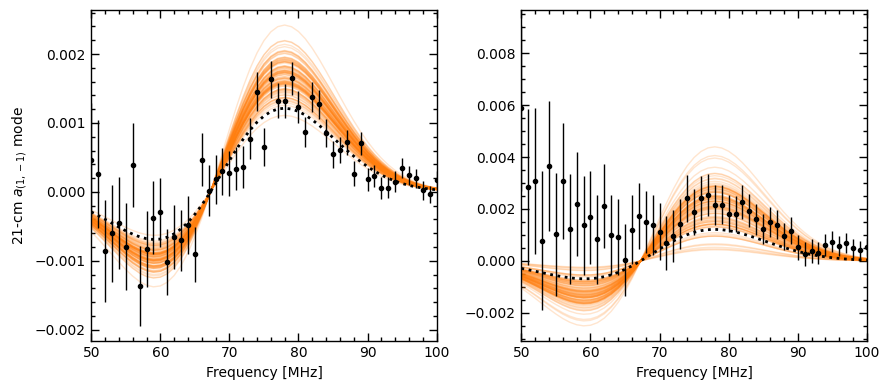

In [20]:
fig, ax = plt.subplots(1,2, figsize=(9,4))
main_res(seed=126, basemap_err=0, t_int=1e5, chrom=None, ax=ax[0])
main_res(seed=126, basemap_err=0.5, t_int=1e5, chrom=None, ax=ax[1])
ax[0].set_ylabel("21-cm $a_{(1,-1)}$ mode")
ax[0].set_xlabel("Frequency [MHz]")
ax[1].set_xlabel("Frequency [MHz]")
ax[0].set_xlim(50,100)
ax[1].set_xlim(50,100)
fig.tight_layout()
fig.savefig('fig/mapmaking_a1m1.pdf')
plt.show()

In [9]:
def main_res_pow(seed=123, basemap_err=0, t_int=1e3, chrom=None, ax=None):
    # Mapmaking pipeline parameters.
    nside   = 32
    lmax = 32
    lmod = 5
    Nlmax   = RS.get_size(lmax)
    Nlmod   = RS.get_size(lmod)
    
    # Observation and binning params.
    Ntau  = None
    Nt    = 24
    times = np.linspace(0, 24, Nt, endpoint=False)
    nuarr = np.linspace(50,100,51)
    lats = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])
    chrom = chrom
    basemap_err = basemap_err  # BASEMAP ERROR
    err_type='idx'
    
    # Cosmological parameters.
    cm21_params = OBS.cm21_params
    
    # Foreground correction reference frequency.
    err_ref = 70
    
    # Generate foreground and 21-cm signal alm
    cm21_alm = SM.cm21_gauss_mondip_alm(nu=nuarr, lmax=lmax, params=OBS.cm21_params_mondip)
    fg_alm   = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, 
        use_mat_Y=True, delta=SM.basemap_err_to_delta(basemap_err, ref_freq=err_ref), 
        err_type=err_type, seed=seed, meancorr=False)
    fid_alm  = fg_alm + cm21_alm
    
    # Generate observation matrix for the modelling and for the observations.
    if chrom is not None:
        if not isinstance(chrom, bool):
            chromfunc = partial(BF.fwhm_func_tauscher, c=chrom)
        else:
            chromfunc = BF.fwhm_func_tauscher
        mat_A = FM.calc_observation_matrix_multi_zenith_driftscan_chromatic(nuarr, nside, lmax, Ntau=Ntau, lats=lats, times=times, return_mat=False, beam_use=BF.beam_cos_FWHM, chromaticity=chromfunc)
        mat_A_mod = mat_A[:,:Nlmod]
    elif chrom is None:
        narrow_cosbeam  = lambda x: BF.beam_cos(x, 0.8)
        mat_A = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, Ntau=Ntau, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=False)
        mat_A = BlockMatrix(mat=mat_A, mode='block', nblock=len(nuarr))
        mat_A_mod = mat_A[:,:Nlmod]
    
    # Perform fiducial observations
    d = mat_A @ fid_alm
    dnoisy, noise_covar = SM.add_noise(d, 1, Ntau=len(times), t_int=t_int, seed=seed)#t_int=100, seed=456)#
    sample_noise = np.sqrt(noise_covar.block[0][0,0])
    print(f"Data generated with noise {sample_noise} K at 50 MHz in the first bin")
    
    # Calculate the missing-modes observation matrix.
    mat_A_unmod = BlockMatrix(mat_A.block[:,:,Nlmod:])
    
    # Generate a missing-modes correction analytically.
    alm_mean, alm_cov = SM.gsma_corr(lmod, lmax, nside, nuarr, basemap_err, ref_freq=err_ref)
    data_corr  = mat_A_unmod @ alm_mean
    covar_corr = mat_A_unmod @ alm_cov @ mat_A_unmod.T
    
    # Reconstruct the max likelihood estimate of the alm
    mat_W, cov = MM.calc_ml_estimator_matrix(mat_A=mat_A_mod, mat_N=noise_covar+covar_corr, cov=True, cond=True)
    if isinstance(cov, BlockMatrix):
        alm_error = np.sqrt(cov.diag)
    else:
        alm_error = np.sqrt(np.diag(cov))
    print("Computing rec alm")
    if isinstance(mat_W, BlockMatrix):
        rec_alm = mat_W @ (dnoisy - data_corr)
    else:
        rec_alm = mat_W @ (dnoisy - data_corr).vector

    # Extract one dipole mode
    a1m1 = rec_alm[1]
    a1m1_err = alm_error[1::Nlmod]

    del mat_A
    del mat_A_mod
    del mat_A_unmod
    del mat_W

    fg_alm = BlockVector(fg_alm,nblock=len(nuarr))
    cm21_alm = BlockVector(cm21_alm,nblock=len(nuarr))

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.errorbar(nuarr, a1m1 - fg_alm[1], a1m1_err, fmt='.')
    ax.plot(nuarr, cm21_alm[1], linestyle=':', color='k')    
    
    

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Data generated with noise 0.0021878574738578437 K at 50 MHz in the first bin
Loaded mean and covar correction for nside<32>_lmax<32>_bmerr<0.5>
1/condition #: 3.847265208122374e-09
Computing rec alm
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Data generated with noise 0.0021878801007486747 K at 50 MHz in the first bin
Loaded mean and covar correction for nside<32>_lmax<32>_bmerr<1>
1/condition #: 2.9209208883218237e-09
Computing rec alm


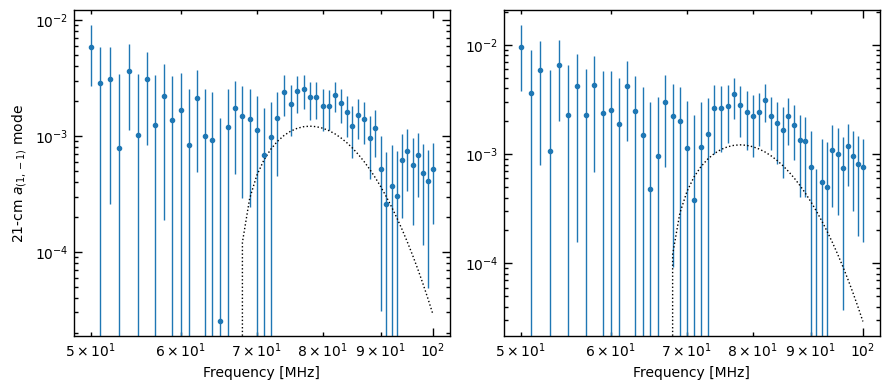

In [10]:
fig, ax = plt.subplots(1,2, figsize=(9,4))
main_res_pow(seed=126, basemap_err=0.5, t_int=1e5, chrom=None, ax=ax[0])
main_res_pow(seed=126, basemap_err=1, t_int=1e5, chrom=None, ax=ax[1])
ax[0].set_ylabel("21-cm $a_{(1,-1)}$ mode")
ax[0].set_xlabel("Frequency [MHz]")
ax[1].set_xlabel("Frequency [MHz]")
fig.tight_layout()
fig.savefig('fig/mapmaking_a1m1_loglog.pdf')
plt.show()

In [390]:
cm21_alm_bl = BlockVector(cm21_alm, nblock=len(nuarr))

In [382]:
a00  = rec_alm[0]
a1m1 = rec_alm[1]
a10  = rec_alm[2]
a1p1 = rec_alm[3]

a00_err  = alm_error[0::Nlmod]
a1m1_err = alm_error[1::Nlmod]
a10_err  = alm_error[2::Nlmod]
a1p1_err = alm_error[3::Nlmod]

In [414]:
def a1m_fg_mod(theta):
    assert len(theta) == 5
    A, alpha = theta[:2]
    zetas    = theta[2:]
    exponent = [zetas[i]*np.log(nuarr/60)**(i+2) for i in range(len(zetas))]
    a1m_fg   = (A*1e3)*(nuarr/60)**(-alpha) * np.exp(np.sum(exponent, 0))
    return np.abs(a1m_fg)

def a1m_mod(theta):
    assert len(theta) == 5 + 1
    theta_fg = theta[:5]
    theta_21 = theta[-1]
    a1m_cm21 = cm21_dipoleT(nuarr, *OBS.cm21_params)
    a1m_fg   = a1m_fg_mod(theta_fg)
    return np.abs(theta_21*a1m_cm21 + a1m_fg)

a1m_mod_cf = lambda nuarr, *theta: a1m_mod(theta)
a1m_fg_mod_cf = lambda nuarr, *theta: a1m_fg_mod(theta)

In [374]:
fid_alm_bl = BlockVector(fid_alm, nblock=len(nuarr))
fid_fg_alm_bl = BlockVector(fg_alm, nblock=len(nuarr))
cm21_alm_bl = BlockVector(cm21_alm, nblock=len(nuarr))

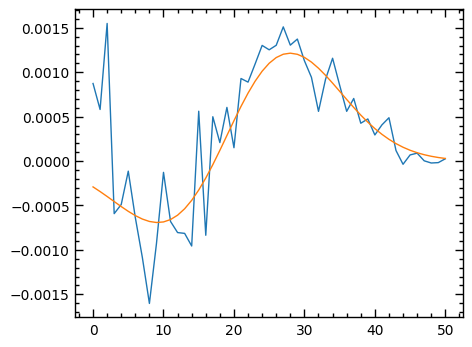

In [375]:
plt.plot(rec_alm[1]-fid_fg_alm_bl[1])
plt.plot(cm21_alm_bl[1])

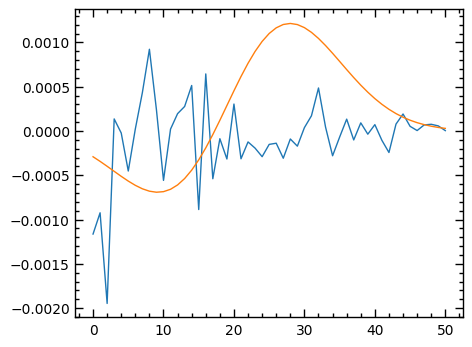

In [287]:
plt.plot(fid_alm_bl[1]-rec_alm[1])
plt.plot(cm21_alm_bl[1])

In [288]:
a00  = rec_alm[0]
a1m1 = rec_alm[1]
a10  = rec_alm[2]
a1p1 = rec_alm[3]

a00_err  = alm_error[0::Nlmod]
a1m1_err = alm_error[1::Nlmod]
a10_err  = alm_error[2::Nlmod]
a1p1_err = alm_error[3::Nlmod]

In [289]:
# First fit these seperately.

In [358]:
def a00_fg_mod(theta):
    assert len(theta) == 7
    A, alpha = theta[:2]
    zetas    = theta[2:]
    exponent = [zetas[i]*np.log(nuarr/60)**(i+2) for i in range(len(zetas))]
    a00_fg   = (A*1e3)*(nuarr/60)**(-alpha) * np.exp(np.sum(exponent, 0))
    return a00_fg + np.sqrt(4*np.pi)*T_CMB

def a1m_fg_mod(theta):
    assert len(theta) == 4
    A, alpha = theta[:2]
    zetas    = theta[2:]
    exponent = [zetas[i]*np.log(nuarr/60)**(i+2) for i in range(len(zetas))]
    a1m_fg   = (A*1e3)*(nuarr/60)**(-alpha) * np.exp(np.sum(exponent, 0))
    return a1m_fg

a00_fg_mod_cf = lambda nuarr, *theta: a00_fg_mod(theta)
a1m_fg_mod_cf = lambda nuarr, *theta: a1m_fg_mod(theta)

In [359]:
res_00  = curve_fit(f=a00_fg_mod_cf, xdata=nuarr, ydata=a00,  sigma=a00_err,  p0=[10, 2, 0.1, 0.1, 0.1, 0.1, 0.1])
res_1m1 = curve_fit(f=a1m_fg_mod_cf, xdata=nuarr, ydata=a1m1, sigma=a1m1_err, p0=[10, 2, 0.1, 0.1])
res_10  = curve_fit(f=a1m_fg_mod_cf, xdata=nuarr, ydata=a10,  sigma=a10_err,  p0=[10, 2, 0.1, 0.1])
res_1p1 = curve_fit(f=a1m_fg_mod_cf, xdata=nuarr, ydata=a1p1, sigma=a1p1_err, p0=[10, 2, 0.1, 0.1])

In [360]:
# Take a look at the residuals

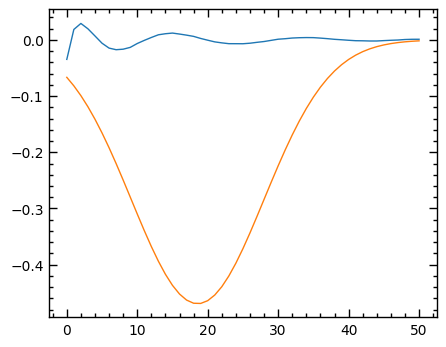

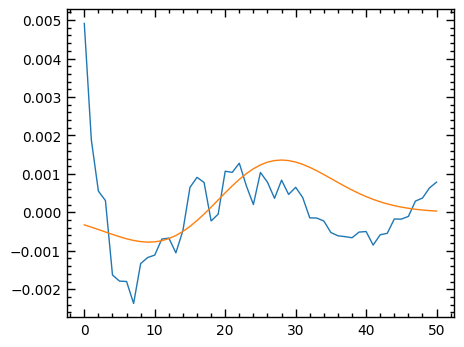

In [361]:
plt.plot(a00 - a00_fg_mod(res_00[0]))
plt.plot(cm21_alm_bl[0])
plt.show()
plt.plot(a1p1 - a1m_fg_mod(res_1p1[0]))
plt.plot(cm21_alm_bl[3])
#plt.plot(a10 - a1m_fg_mod(res_10[0]))
#plt.plot(a1p1 - a1m_fg_mod(res_1p1[0]))

In [209]:
# Good. Now try fitting a single monopole component with MCMC.

In [364]:
def a00_mod(theta):
    assert len(theta) == 7 + 3
    theta_fg = theta[:7]
    theta_21 = theta[7:]
    a00_cm21 = SM.cm21_globalT(nuarr, *theta_21)*np.sqrt(4*np.pi)
    a00_fg   = a00_fg_mod(theta_fg)
    return a00_cm21 + a00_fg

def a1m_mod(theta):
    assert len(theta) == 4 + 4
    theta_fg = theta[:4]
    theta_21 = theta[4:]
    a1m_cm21 = SM.cm21_dipoleT(nuarr, *theta_21)[1]
    a1m_fg   = a1m_fg_mod(theta_fg)
    return a1m_cm21 + a1m_fg


In [365]:
nwalkers = 64
ndim     = 3 + 3
steps    = 3000
burn_in  = 2000

p0     = list(res_00[0]) + OBS.cm21_params
p0 = np.array(p0)
pos    = p0*(1 + 1e-4*np.random.randn(nwalkers, ndim))
priors = [[1, 25], [1.5, 3.5], [-2, 2.1], [-1.,-0.01], [50,90], [3, 15]]
priors = np.array(priors)

sampler = EnsembleSampler(nwalkers, ndim, INF.log_posterior, 
                    args=(a00, a00_err, a00_mod, priors))
_=sampler.run_mcmc(pos, nsteps=steps, progress=True, skip_initial_state_check=True)
chain_mcmc = sampler.get_chain(flat=True, discard=burn_in)

ValueError: operands could not be broadcast together with shapes (10,) (64,6) 

/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_62603/2469361507.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


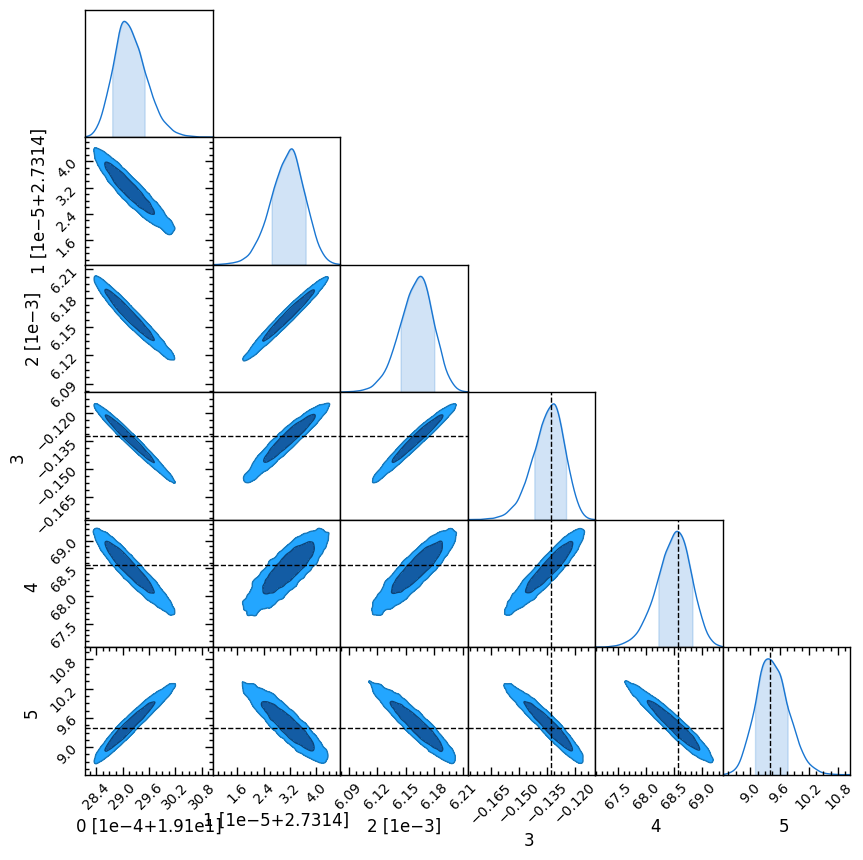

In [212]:
c = ChainConsumer()
c.add_chain(chain_mcmc)
f = c.plotter.plot(truth=p0)
f.show()

In [366]:
def full_mod(theta):
    assert len(theta) == 7 + 3*4 + 3 + 3 # fgmon poly, fgdip polys, 21cm monopole and 21cm dipole.
    theta = list(theta)
    
    theta_fg = theta[:7+3*4]
    theta_21 = theta[7+3*4:]
    
    theta_fg_mon  = theta_fg[:7]
    theta_fg_dip1 = theta_fg[7:7+4]
    theta_fg_dip2 = theta_fg[7+4:7+2*4]
    theta_fg_dip3 = theta_fg[7+2*4:]

    theta_cm21_mon = theta_21[:3]
    theta_cm21_dip = theta_21[3:]

    # Want to return [monopole] + [dipole1] + [dipole2] + [dipole3]
    # Dipole components.
    dip1 = a1m_mod(theta_fg_dip1+theta_cm21_mon+[theta_cm21_dip[0]])
    dip2 = a1m_mod(theta_fg_dip2+theta_cm21_mon+[theta_cm21_dip[1]])
    dip3 = a1m_mod(theta_fg_dip3+theta_cm21_mon+[theta_cm21_dip[2]])

    mon  = a00_mod(theta_fg_mon+theta_cm21_mon)

    tot  = np.zeros(len(nuarr)*4)
    tot[0:len(nuarr)]              = mon
    tot[len(nuarr):2*len(nuarr)]   = dip1
    tot[2*len(nuarr):3*len(nuarr)] = dip2
    tot[3*len(nuarr):]             = dip3
    return tot
    

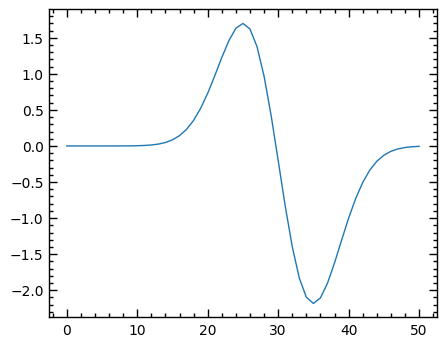

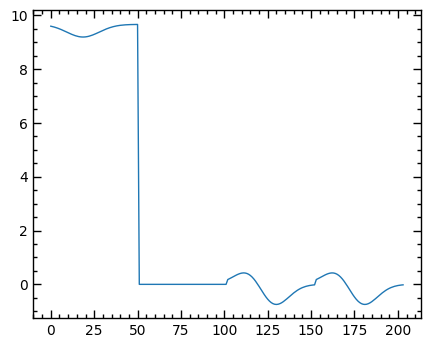

In [368]:
plt.plot(a1m_mod([0,0,0,0,-0.2,80,5,1]))
plt.show()
plt.plot(full_mod([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0, 0, 0]+OBS.cm21_params+[0,1,1]))

In [236]:
# Okay things seem to be working. Now let's go for the full thing!

In [369]:
p0 = (
    list(res_00[0])
    + list(res_1m1[0])
    + list(res_10[0])
    + list(res_1p1[0])
    + OBS.cm21_params
    + [1e-3, 1e-3, 1e-3]
)
p0

[19.080966972789916,
 2.730159404896642,
 0.005326683434545138,
 0.003040595398243713,
 0.007856753640345233,
 -0.039825682526404886,
 0.036278155999003636,
 1.6395516422012364,
 2.551801823643404,
 -0.025673967654071782,
 0.004070715201539815,
 0.39613930343547127,
 2.640211657818089,
 0.007821197060472131,
 -0.0018139482557961932,
 -6.121500290517633,
 2.553488115158757,
 -0.009160710110075009,
 0.001414623318344005,
 -0.13242,
 68.57,
 9.399,
 0.001,
 0.001,
 0.001]

In [250]:
yerr[0:2*len(nuarr)]

array([0.02400707, 0.0225354 , 0.02117826, 0.01992486, 0.01876558,
       0.01769187, 0.01669607, 0.01577134, 0.01491152, 0.01411111,
       0.01336512, 0.01266907, 0.01201891, 0.01141097, 0.01084194,
       0.01030879, 0.00980879, 0.00933943, 0.00889844, 0.00848374,
       0.00809344, 0.0077258 , 0.00737921, 0.00705223, 0.0067435 ,
       0.0064518 , 0.00617599, 0.00591501, 0.0056679 , 0.00543378,
       0.00521181, 0.00500123, 0.00480133, 0.00461146, 0.004431  ,
       0.0042594 , 0.00409613, 0.00394069, 0.00379264, 0.00365155,
       0.00351702, 0.00338869, 0.0032662 , 0.00314925, 0.00303752,
       0.00293073, 0.00282862, 0.00273095, 0.00263747, 0.00254797,
       0.00246226, 0.02434593, 0.02285414, 0.02147846, 0.02020795,
       0.01903286, 0.01794451, 0.01693514, 0.01599782, 0.0151263 ,
       0.014315  , 0.01355886, 0.01285335, 0.01219435, 0.01157815,
       0.01100138, 0.01046098, 0.00995417, 0.00947843, 0.00903144,
       0.0086111 , 0.00821548, 0.00784282, 0.00749151, 0.00716

In [378]:
nwalkers = 64
ndim     = 7 + 3*4 + 3 + 3
steps    = 100000
burn_in  = 80000

p0 = (
    list(res_00[0])
    + list(res_1m1[0])
    + list(res_10[0])
    + list(res_1p1[0])
    + OBS.cm21_params
    + [1e-3, 1e-3, 1e-3]
)
p0     = np.array(p0)
pos    = p0*(1 + 1e-2*np.random.randn(nwalkers, ndim))

priors = [
    [1, 25],   # fg poly
    [1.5, 3.5], 
    [-2, 2.1], 
    [-0.1, 0.11],
    [-0.1, 0.11],
    [-0.1, 0.11],
    [-0.1, 0.11],
    [-1, 4],   # cm21 poly1
    [1.5, 3.5], 
    [-2, 2.1], 
    [-0.011, 0.01], 
    [-1, 4],   # cm21 poly2
    [1.5, 3.5], 
    [-2, 2.1], 
    [-0.011, 0.01], 
    [-10, -1],   # cm21 poly3
    [1.5, 3.5], 
    [-2, 2.1], 
    [-0.011, 0.01], 
    [-1.,-0.01],   # cm21 mon pars
    [50,90], 
    [3, 15],
    [1e-4, 1e-2],  # cm21 dip pars
    [1e-4, 1e-2],
    [1e-4, 1e-2]
]
priors = np.array(priors)

y  = np.zeros(len(nuarr)*4)
y[0:len(nuarr)]              = a00
y[len(nuarr):2*len(nuarr)]   = a1m1
y[2*len(nuarr):3*len(nuarr)] = a10
y[3*len(nuarr):]             = a1p1

yerr = np.zeros(len(nuarr)*4)
yerr[0:len(nuarr)]              = a00_err
yerr[len(nuarr):2*len(nuarr)]   = a1m1_err
yerr[2*len(nuarr):3*len(nuarr)] = a10_err
yerr[3*len(nuarr):]             = a1p1_err

sampler = EnsembleSampler(nwalkers, ndim, INF.log_posterior, 
                    args=(y, yerr, full_mod, priors))
_=sampler.run_mcmc(pos, nsteps=steps, progress=True, skip_initial_state_check=True)
chain_mcmc = sampler.get_chain(flat=True, discard=burn_in)

100%|███████████████████████████████████| 100000/100000 [38:32<00:00, 43.24it/s]


/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_62603/2469361507.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


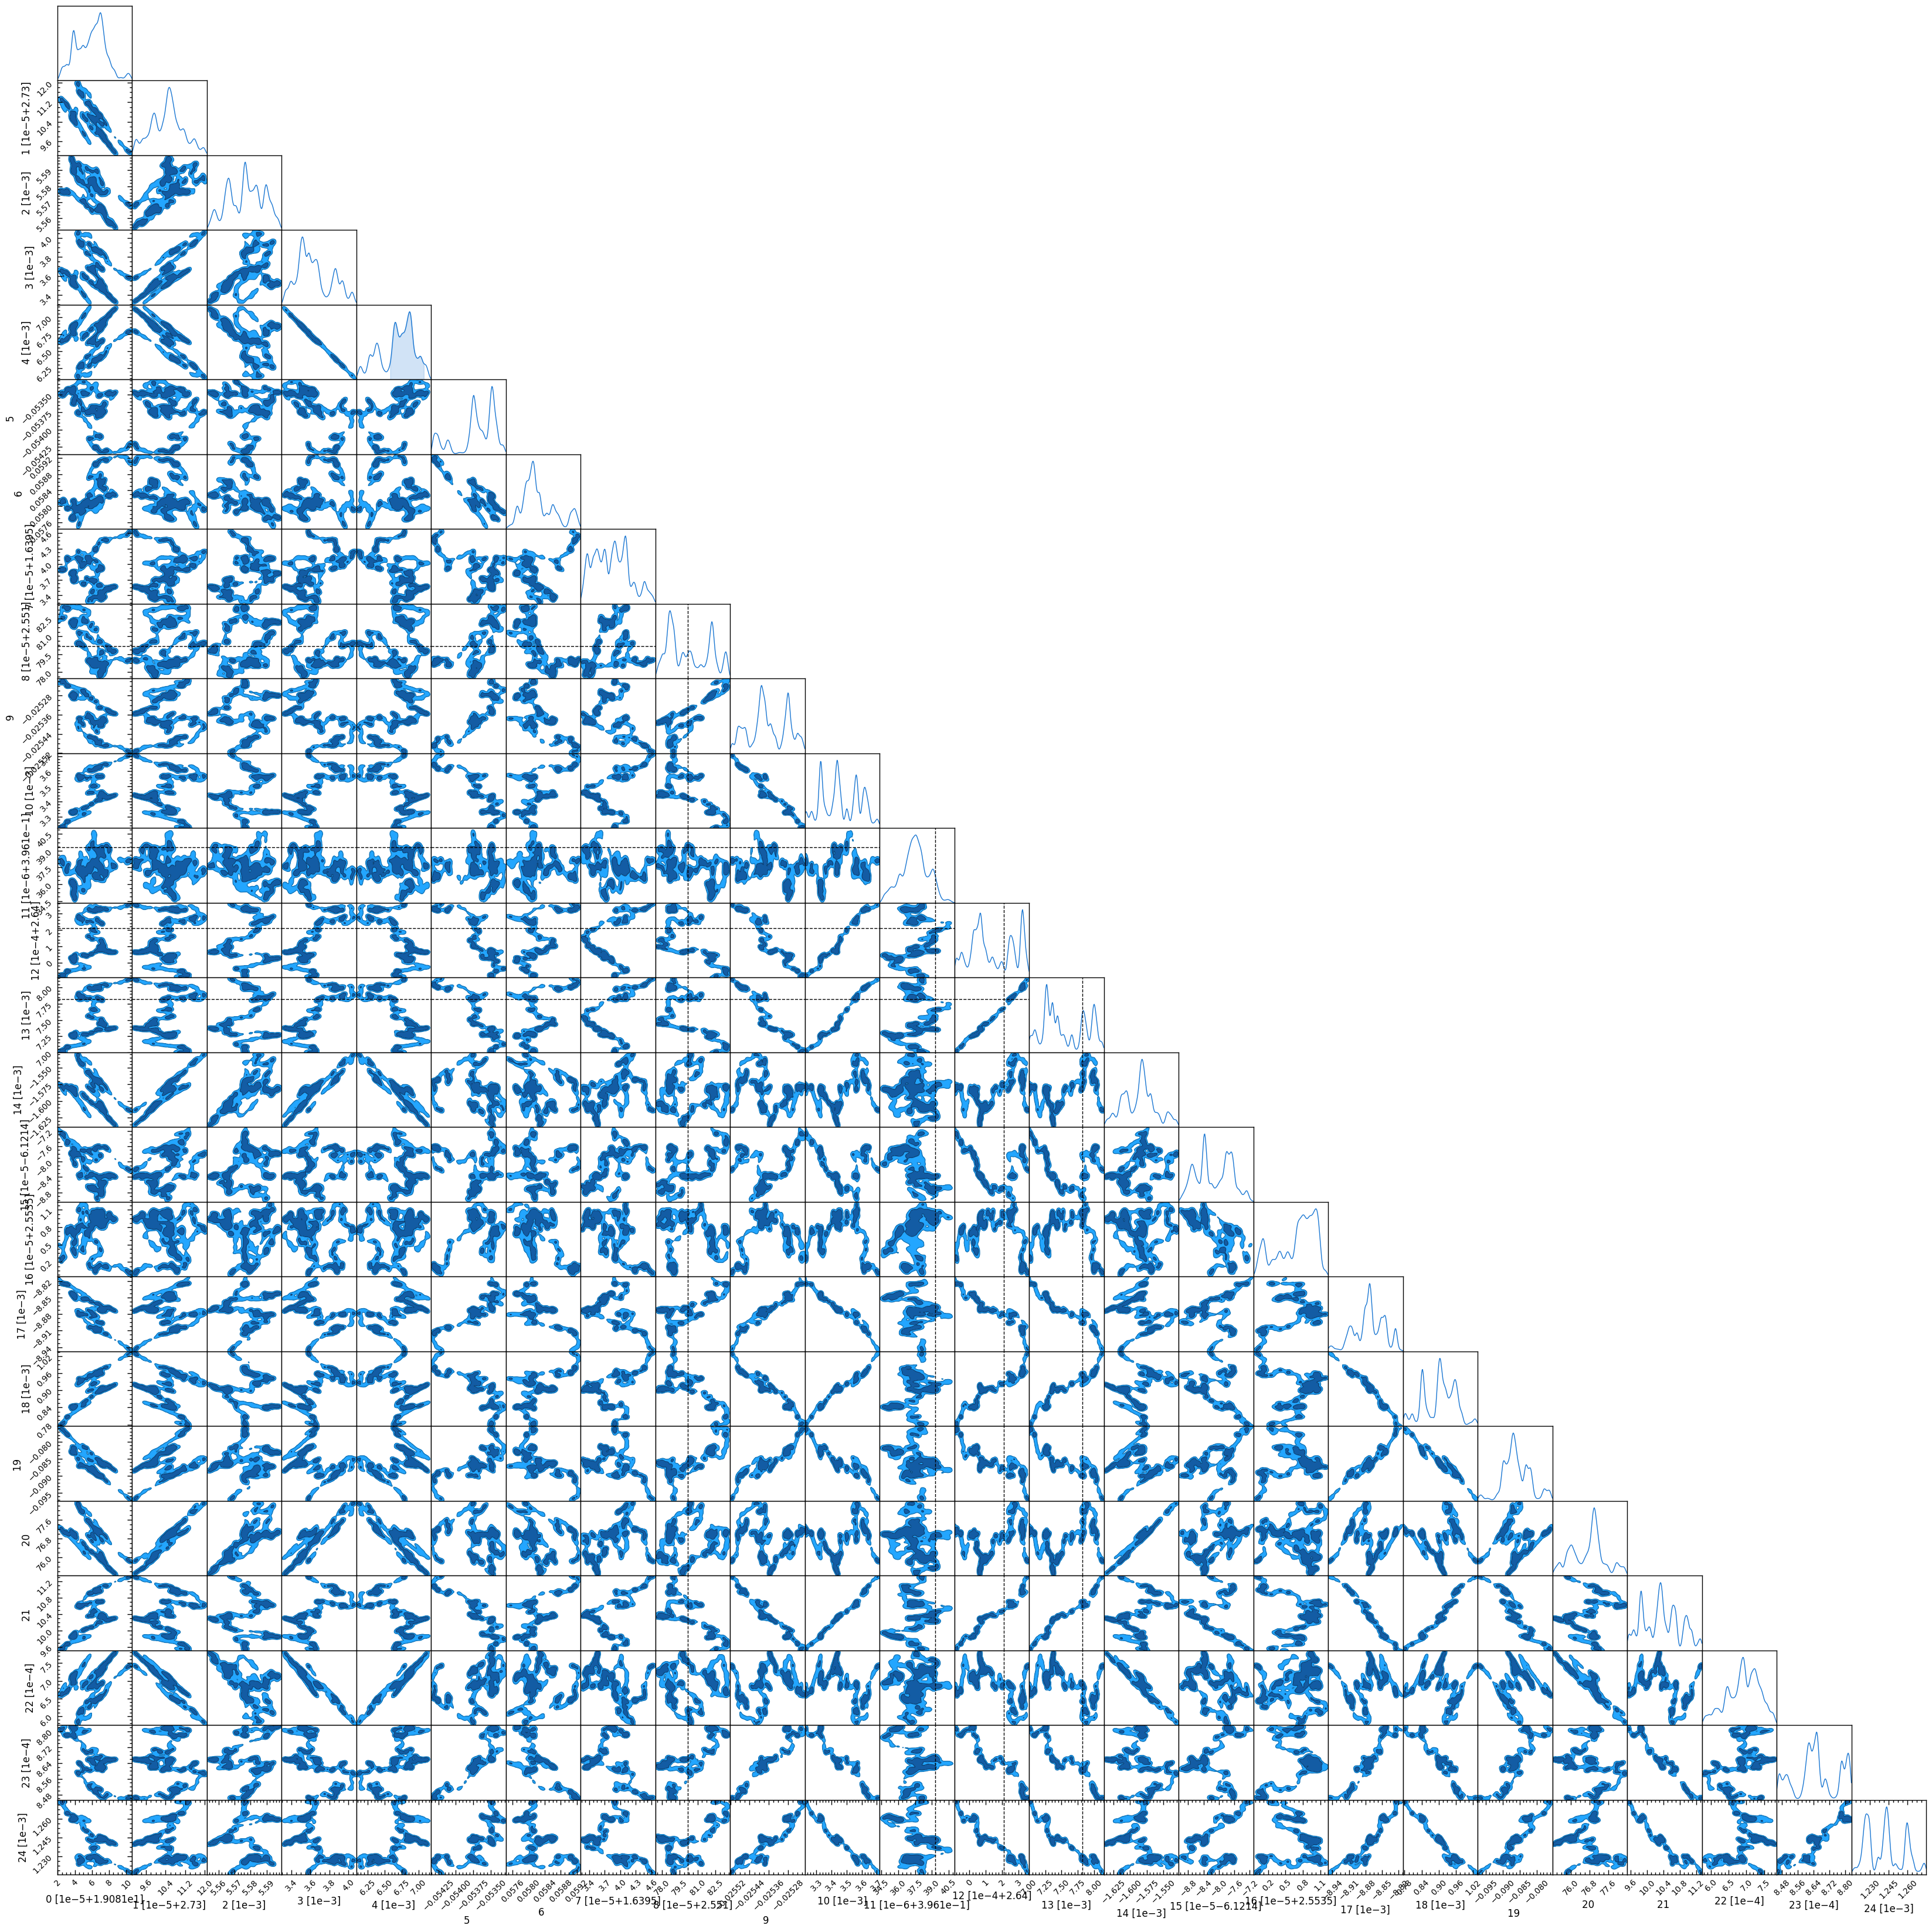

In [379]:
c = ChainConsumer()
c.add_chain(chain_mcmc)
f = c.plotter.plot(truth=p0)
f.show()

/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_62603/2451020791.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


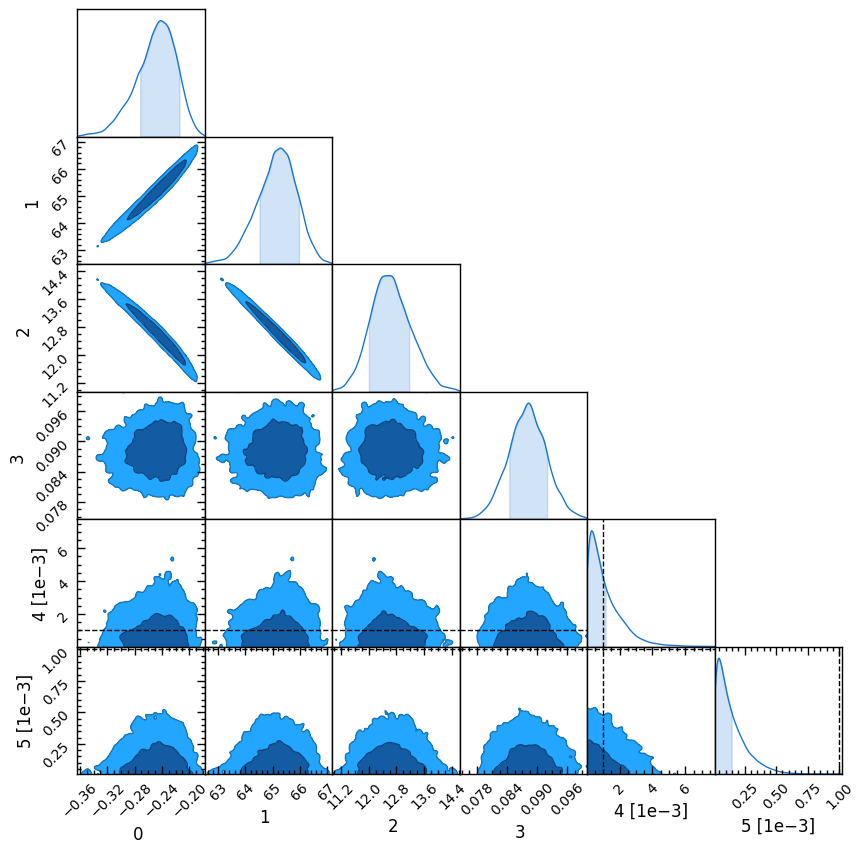

In [221]:
c = ChainConsumer()
c.add_chain(chain_mcmc[:,-6:])
f = c.plotter.plot(truth=p0[-6:])
f.show()

In [260]:
fid_alm[0::Nlmax]-a00

array([-44.25438859, -40.99206811, -38.01647052, -35.29835347,
       -32.81714662, -30.53663936, -28.44885114, -26.53320405,
       -24.76488928, -23.13891657, -21.64154289, -20.25531451,
       -18.9785452 , -17.79195207, -16.69428631, -15.68132416,
       -14.73671287, -13.85602348, -13.04119594, -12.28317901,
       -11.5753667 , -10.91466101, -10.2993446 ,  -9.7244793 ,
        -9.1860346 ,  -8.68355582,  -8.21174937,  -7.77203851,
        -7.35817069,  -6.97033008,  -6.60496259,  -6.2599783 ,
        -5.93926288,  -5.63597664,  -5.35190529,  -5.08300316,
        -4.83026726,  -4.590585  ,  -4.36542821,  -4.15359266,
        -3.95189574,  -3.76265543,  -3.58348682,  -3.41386267,
        -3.25350338,  -3.1010995 ,  -2.95778177,  -2.82131421,
        -2.69250524,  -2.56955622,  -2.45231787])